##Download and prepare datasets

Device: cuda:0
EuroSAT_RGB train_dataset found
train train_dataset found


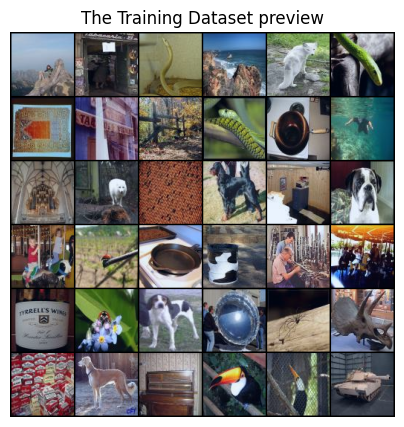

In [1]:

import os
import random
import zipfile
import tarfile

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.utils as utils
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torchvision import models
import torch.optim as optim
import random

#enabe gpu if available with cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# paths
eurosat_path = "data/EuroSAT_RGB"
train_tar_path = "data/train"

# images sizes
tar_image_size = 84
eurosat_image_size = 64

### HYPERPARAMETERS
batch_size = 64
num_workers = 1
lr = 0.0003
num_epochs = 6
num_classes_train = 64
num_classes_euroSAT = 10

# mean and std values
mean = mean=[0.485, 0.456, 0.406]
std = std=[0.229, 0.224, 0.225]

# Image Size
tar_image_size = 84
eurosat_image_size = 64


# transforms
transform1 = transforms.Compose([
    transforms.Resize((tar_image_size, tar_image_size)),  # Resize to a common size
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

transform2 = transforms.Compose([
    transforms.Resize((eurosat_image_size, eurosat_image_size)),  # Resize to a common size
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# check data exists
try: 
    if os.path.exists(eurosat_path):
        print("EuroSAT_RGB train_dataset found")
    elif os.path.exists(eurosat_path + ".zip"):
        print("train.tar train_dataset found, unzipping...")
        with zipfile.ZipFile(eurosat_path + ".zip", "r") as zf:
            print("Opened zipfile")
            zf.extractall("data/")
            print("EuroSAT_RGB.zip extracted")
except FileNotFoundError:
    print("The file data/EuroSAT_RGB was not found")

train_tar_path = "data/train"
try: 
    if os.path.exists(train_tar_path):
        print("train train_dataset found")
    elif os.path.exists(train_tar_path + ".tar"):
        print("train.tar train_dataset found, unzipping...")
        with tarfile.open(train_tar_path + ".tar", "r") as tf:
            print("Opened tarfile")
            tf.extractall(path="data/")
            print("train.tar extracted")
except FileNotFoundError:
    print("train data was not found")


# load data
train_tar_load = datasets.ImageFolder(train_tar_path, transform=transform1) # train data
eurosatdata_load = datasets.ImageFolder(eurosat_path, transform=transform2) # fine tuning data

# Splitting the train train_dataset into train, val, and test
data_len = len(train_tar_load)
test_tar = int(data_len  * 0.15)
valid_tar = test_tar
train_tar = len(train_tar_load) - test_tar * 2

train_dataset, val_dataset, test_dataset = random_split(train_tar_load, [train_tar, valid_tar, test_tar])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The Training Dataset preview')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))
plt.show()


#

## Pretrain a model

In [2]:
#model selection
model = models.vgg16(weights='IMAGENET1K_V1') # load pretrained model

# match output dim with num of classes
model.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes_train, bias=True)

# Loss and optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.002, momentum=0.9)

# evaluation function
def evaluate_model(model, loader):
    """
    Evaluate the performance of the model
    """
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()
    model.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = model(images) 
#         _, preds = outs.max(1)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# training function
def train(model, train_loader, valid_loader=None, validate=True, n_epochs=num_epochs):
    """
    Train the model
    """
    loss_function = torch.nn.CrossEntropyLoss()
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()
            
    for epoch in range(n_epochs):
        model.train() 
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            #forward 
            outputs = model(images)
            loss = loss_function(outputs, labels)
            preds = outputs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            num_images += labels.size(0)
            # backward
            loss.backward()
            optimizer.step()
        
        acc = correct / num_images
        if validate:
            acc_eval = evaluate_model(model, valid_loader)
            print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch+1, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))
        else:
            print('epoch: %d, lr: %f, accuracy: %f, loss: %f' % (epoch+1, optimizer.param_groups[0]['lr'], acc, loss.item()))

    return model


print('Please wait patiently, it may take some seconds...')
network = train(model, train_loader, val_loader)
acc_test = evaluate_model(network, test_loader)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

torch.save(model.state_dict(), 'models/preTrained_model.pth')


Please wait patiently, it may take some seconds...
epoch: 1, lr: 0.000300, accuracy: 0.500298, loss: 1.605682, valid accuracy: 0.713194
epoch: 2, lr: 0.000300, accuracy: 0.722470, loss: 0.781079, valid accuracy: 0.740104
epoch: 3, lr: 0.000300, accuracy: 0.773512, loss: 0.876184, valid accuracy: 0.757292
epoch: 4, lr: 0.000300, accuracy: 0.813542, loss: 0.838410, valid accuracy: 0.760590
epoch: 5, lr: 0.000300, accuracy: 0.848289, loss: 0.521270, valid accuracy: 0.765799
epoch: 6, lr: 0.000300, accuracy: 0.871987, loss: 0.253413, valid accuracy: 0.771875
accuracy on testing data: 0.775000


##Fine-tuning with EuroSAT dataset

Make sure the model is functinal after reloading...
accuracy on testing data with new model w/o fine tuning: 0.775000
Should match the value after pre-training
check dict. category:amount
{1: 5, 2: 5, 9: 5, 5: 5, 3: 5}
len of train images  25
len of test images  75
Starting new training iteration...
Please wait patiently, it may take some seconds...
epoch: 1, lr: 0.000300, accuracy: 0.200000, loss: 1.617332
epoch: 2, lr: 0.000300, accuracy: 0.720000, loss: 0.926129
epoch: 3, lr: 0.000300, accuracy: 0.920000, loss: 0.286561
epoch: 4, lr: 0.000300, accuracy: 1.000000, loss: 0.066185
epoch: 5, lr: 0.000300, accuracy: 1.000000, loss: 0.006814
epoch: 6, lr: 0.000300, accuracy: 0.960000, loss: 0.707905
accuracy on epoch 0 testing data: 0.813333
check dict. category:amount
{9: 5, 6: 5, 2: 5, 1: 5, 5: 5}
len of train images  25
len of test images  75
Starting new training iteration...
Please wait patiently, it may take some seconds...
epoch: 1, lr: 0.000300, accuracy: 0.720000, loss: 2.206748


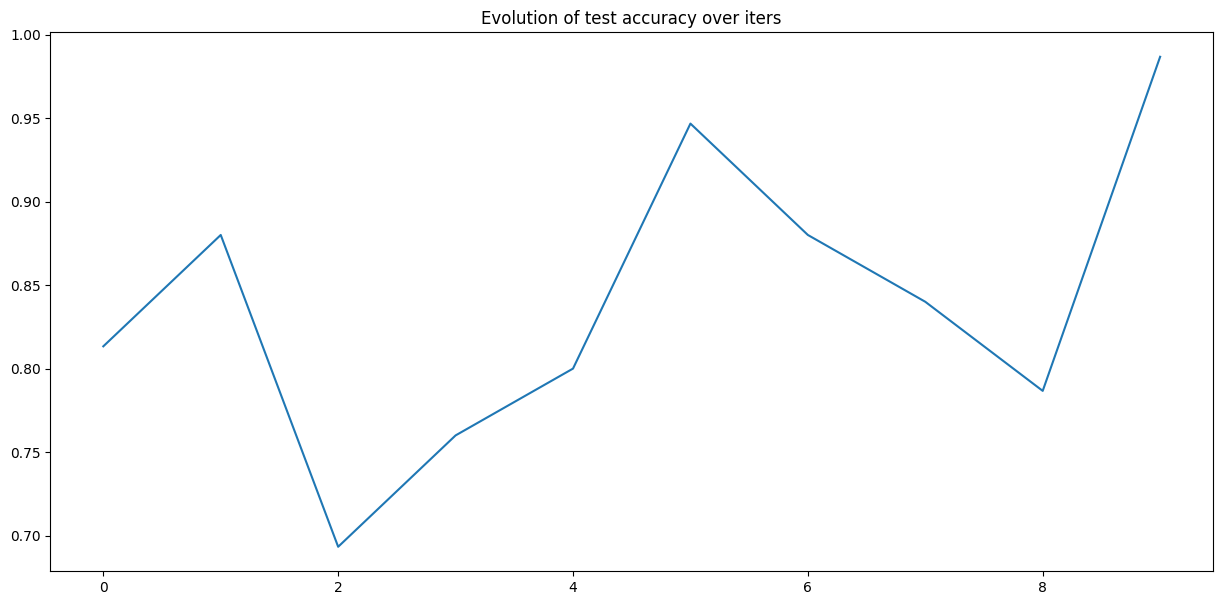

In [3]:
#makes dictrionary that maps indices back to class names.
euroSAT_idx_to_class = {v: k for k, v in eurosatdata_load.class_to_idx.items()}


def select_images(dataset, num_categories=5, images_per_category=20):
    """
    select 100 images across 5 categories 20 images form each
    """
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    selected = []
    for i in range(num_categories):
        index = torch.randint(0, len(classes), (1,))
        class_ = classes.pop(index)
        class_filtered = [(image, label) for image, label in dataset if label == class_]
        selected_indexes = torch.randperm(len(class_filtered))[:images_per_category]
        for i in selected_indexes:
            selected.append(class_filtered[i])
    return selected

#
def split_data(selected_images, num_categories=5, images_per_train_category=5):
    """
    split into training and test sets
    """
    random.shuffle(selected_images)
    
    train_images = []
    test_images = []

    # Initialize a dictionary to count images per category in the training set
    category_count = {class_name: 0 for class_name in euroSAT_idx_to_class.values()}

    for img_path, class_idx in selected_images:
        class_name = euroSAT_idx_to_class[class_idx]
        if category_count[class_name] < images_per_train_category:
            train_images.append((img_path, class_idx))
            category_count[class_name] += 1
        else:
            test_images.append((img_path, class_idx))

    return train_images, test_images

# initiate data class
class CustomDataset(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path, label = self.img_list[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Reload saved model
pretrained_model = torch.load('models/preTrained_model.pth')
model2 = models.vgg16()
# match dimensins of models
model2.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes_train, bias=True)
model2.load_state_dict(pretrained_model)

print("Make sure the model is functinal after reloading...")
print('accuracy on testing data with new model w/o fine tuning: %f' % evaluate_model(model2, test_loader))
print("Should match the value after pre-training")

# freeze existing layers
# prevent training of already acquired knowledge
for param in model2.parameters():
    param.requires_grad = False

# create few additional layers to learn new information
model2.classifier = nn.Sequential(nn.Linear(25088, 2048),
                nn.ReLU(),
                nn.Linear(2048,1024),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(1024, 256),
                nn.ReLU(),
                nn.Linear(256,10))

optimizer = optim.Adam(model2.parameters(), lr=lr)

results = []

for i in range(10):
    # select images
    selected_images = select_images(eurosatdata_load)
    train_images, test_images = split_data(selected_images)
    train_loader_eurosat = DataLoader(train_images, batch_size=5, shuffle=True)
    test_loader_eurosat = DataLoader(test_images, batch_size=5, shuffle=True)
    check_dict = {}
    for j in range(len(train_images)):
        if train_images[j][1] in check_dict:
            check_dict[train_images[j][1]] += 1
        else:
            check_dict[train_images[j][1]] = 1
    # check class number and amount in train dataset
    print("check dict. category:amount")
    print(check_dict) # just a debug print
    print("len of train images ", len(train_images))
    print("len of test images ", len(test_images))
    print("Starting new training iteration...")
    # train model
    print('Please wait patiently, it may take some seconds...')
    model2 = train(model2, train_loader=train_loader_eurosat, validate=False, n_epochs=6)
    # test model
    acc_test2 = evaluate_model(model2, test_loader_eurosat)
    print(f'accuracy on epoch {i} testing data: %f' % acc_test2)
    results.append(acc_test2.item())

# print out final results after fine tuning
print(results)
print("avg of all fine tuning iters: ", (sum(results) / len(results)))
f = plt.figure(figsize=(15,7))
plt.title("Evolution of test accuracy over iters")
plt.plot(range(len(results)), results)
plt.show()


##Model comparison and optimization

##Evaluation on additional dataset (bonus tasks)